# @kanyewest vs @Kantye_West classifier

First let's have a quick look at the datasets provided

In [1]:
%matplotlib inline
import pandas as pd

positive_df = pd.read_json("kanyewest.json")
negative_df = pd.read_json("kantye_west.json")
positive_df.sample(8)

,id,text
182,989222392630202400,we got love https://t.co/Edk0WGscp6
98,990336500058406900,today is the best day ever and tomorrow's goin...
473,988128539231711200,there was a time when slavery was the trend an...
205,993584928930451500,It’s about the feeling first https://t.co/4x2w...
212,992962234102857700,All music coming out of Yeezy sound has to rid...
77,990698030939582500,we're being starved and anyone who starts aski...
78,990697283174858800,we’re in this so-called information age but we...
223,991856491626840000,https://t.co/IxydIAseI0


In [2]:
negative_df.sample(8)

,id,text
38,956935640460996600,Ludacris made more sense than Hume.
316,835335478819827700,Do you even think bro?
251,936644744595243000,Cogito coco channel
106,847278343581872100,"Heidegger was buggin when he wrote ""Being and ..."
4,988192406444032000,🤯 https://t.co/HmxwVEwncm
283,901095491332689900,808's and intellectual jailbreaks
374,702255708893540400,Donald Trump couldn't reason his way out of pa...
196,684504865918312400,Yeah I read me some Hegel. It was aight.


In [3]:
positive_df.count()

id      575
text    575
dtype: int64

In [4]:
negative_df.count()

id      481
text    481
dtype: int64

## First impressions
* really little data
* classes are fairly balanced. probably don't need to do oversampling
* text is not curated but that may contain strong indication of the fake vs real kanye account
* can we get more data? @kanyewest seems to have deleted his tweeter account. @Kantye_West seems to have less tweets than in the dataset.
* given the domain and including twitter handles, potential vocab can be huge. But then again there's little data which will probably have very few samples from which word
* ideally the parameters of the model shouldn't be more than the size of the training data. But with such little data the model needs to be very simple

## First thought on approaches

#### Simple bag-of-words model
* It's simple and quick to do.
* Little training data, out-of-vocab words will abound (will likely bias to predict the majority class).
* Possibly include 2-grams or tri-grams.
* Include both the normalized text and non-normalized text in the vocab.
* Possibly include subword information alla fast text
* Given the little training data, investigate the vocab size. It may not be good to have a large vocab and main be better to reduce it significantly. E.g. only use words that appear more than X times in the training set.

#### Use the word embedding of each word in the tweet as the input
* Ideally would train a word embedding model on a large amount of tweets
* Could get a pre-trained embedding. If there is none existing for twitter there may be vocab and domain mismatch
* Typically approaches of aggregating (averaging / summing / min / max) the embeddings of the words in the tweet probably will work reasonably but not great
* If one want's to improve on those aggregations probably would need to use a CNN-like approach

#### Other alternatives: probably out of scope
* use CNN on the embedding input
* try non-linear layer(s)
* train a paragraph2vec model on tweets, use the paragraph vectors to train a classifier
* apply unsupervised techniques / dimentionality reduction techniques on tweet text and train the classifier on a internal layer. E.g. autoencoder, DBN, etc.

## Preparing the input

* I'm working under the assumption that text normalization features are important. E.g. puctuation used, caps, etc.
* For now will have a tokenizer that splits on whitespaces and puctuation.
* Will not include the @ in the punctuation list. Most likely it will be used in twitter handles which is an important aspect of the domain to capture.
* Will lowercase the text for now, ideally would model capitalization, e.g. lowercase, capitalized, all_caps, mixed
* Ideally much better processing would be done. It won't be good at capturing things like URLs and definitely won't work on languages like Thai, etc
* Probably emoji should be split as well

In [5]:
import re
import string

class Tokenizer(object):
    SPLIT_RE = re.compile(r"(@\w+|\w+|\S)|[^\s]", re.UNICODE)
    
    @staticmethod
    def split(text):
        return Tokenizer.SPLIT_RE.findall(text.lower())

Tokenizer.split("@ruiaf, does     this; work? 🙌🙌🙌 Hi, maybe")

['@ruiaf',
 ',',
 'does',
 'this',
 ';',
 'work',
 '?',
 '🙌',
 '🙌',
 '🙌',
 'hi',
 ',',
 'maybe']

In [6]:
positive_df['label']=1.0
negative_df['label']=0.0
df = pd.concat([positive_df, negative_df]).sample(frac=1.0)
df['tokenized_text'] = [Tokenizer.split(a) for a in df['text']]
df.sample(8)

,id,text,label,tokenized_text
406,989165838803517400,I leave my emojis bart Simpson color,1.0,"[i, leave, my, emojis, bart, simpson, color]"
11,993212368225124400,naps are awesome,1.0,"[naps, are, awesome]"
105,848578203820187600,Now I ain't saying she's a transcendental idea...,0.0,"[now, i, ain, ', t, saying, she, ', s, a, tran..."
439,988797264528228400,me and Mike 😂 https://t.co/E79Uja1sBs,1.0,"[me, and, mike, 😂, https, :, /, /, t, ., co, /..."
153,750874174323822600,Thoughts without contents are yeezy\nIntuition...,0.0,"[thoughts, without, contents, are, yeezy, intu..."
440,370616614510927900,"LL Cool J could have been wrong when he said ""...",0.0,"[ll, cool, j, could, have, been, wrong, when, ..."
357,989279164464119800,https://t.co/tB8SlAjIfV,1.0,"[https, :, /, /, t, ., co, /, tb8slajifv]"
145,989554344457453600,I really appreciate this dialogue with John Le...,1.0,"[i, really, appreciate, this, dialogue, with, ..."


## Preparing the training data

In [7]:
import numpy as np

# I would typically use a validation set to tune hyperparams but
# with so little data it's unlikely we can have relevant hyperparameters
# to tune. In this case it seems like waisting training data.
test_set_share = 0.1

mask = np.random.rand(len(df)) < test_set_share
train_df = df[~mask]
test_df = df[mask]

test_df.sample(8)

,id,text,label,tokenized_text
349,989541974070837200,https://t.co/L9a7OeywJ6,1.0,"[https, :, /, /, t, ., co, /, l9a7oeywj6]"
367,731467514010566700,What can I know? What ought I to do? What can ...,0.0,"[what, can, i, know, ?, what, ought, i, to, do..."
455,988454975738069000,https://t.co/0u9NnvAQ17,1.0,"[https, :, /, /, t, ., co, /, 0u9nnvaq17]"
75,912820074171560000,@williamkrau Zizekgeist,0.0,"[@williamkrau, zizekgeist]"
313,989696353952387100,https://t.co/Sd8YC2ZAcf,1.0,"[https, :, /, /, t, ., co, /, sd8yc2zacf]"
469,232881534061932540,"I have no knowledge of myself as I am, but mer...",0.0,"[i, have, no, knowledge, of, myself, as, i, am..."
202,993629062454067200,https://t.co/5Fe6LJqAQo,1.0,"[https, :, /, /, t, ., co, /, 5fe6ljqaqo]"
87,990687143218462700,energy is contagious,1.0,"[energy, is, contagious]"


In [8]:
# I'm considering to use the hashing trick instead of having an actual
# vocab. But given the assumption that it may be useful to only consider
# words that have been seen at least X times, it's probably not feasible.
# It would definitely make considering bigrams and subwords easier to handle.
# I'm a big fan of the hashing trick for all the above reasons + it acts like
# regularization.

# Probably other ideas to clean the vocab could be used. E.g. num of distinct tweets. etc
class Vocab(object):
    OOV = 0
    
    def __init__(self, tokenized_tweets, min_num_occurences=0):
        self.word_counts = {}
    
        for tweet in tokenized_tweets:
            for token in tweet:
                if token not in self.word_counts:
                    self.word_counts[token] = 0
                self.word_counts[token] += 1
            
        kept_words = [word for word, count in self.word_counts.items() if count > min_num_occurences]
        kept_words.sort(reverse=True)
        self.words = {}
        for word in kept_words:
            self.words[word] = len(self.words)+1
    
    def __len__(self):
        return len(self.words) + 1
    
    def encode(self, token):
        if token in self.words:
            return self.words[token]
        return self.OOV

vocab_full = Vocab(train_df.tokenized_text)
vocab_clean = Vocab(train_df.tokenized_text, min_num_occurences=2)
print("Full vocab size: %d" % len(vocab_full))
print("Clean vocab size: %d" % len(vocab_clean))

Full vocab size: 2422
Clean vocab size: 801


## Encoding the input with a bag of words approach

In [9]:
class BowEncoder(object):
    def __init__(self, vocab):
        self.vocab = vocab
    
    # encode as a a BoW. Normalize on the length of the tweet
    def encode(self, tokenized_text):
        vec = np.zeros(len(self.vocab))
        for token in tokenized_text:
            vec[self.vocab.encode(token)] += 1.0 / len(tokenized_text)
        return vec

class BowDataset(object):
    def __init__(self, df, min_num_occurences=0, vocab=None):
        self.vocab = vocab if vocab is not None else Vocab(train_df.tokenized_text, min_num_occurences)
        encoder = BowEncoder(self.vocab)
        self.examples = np.array([
            encoder.encode(tokenized_text)
            for tokenized_text in df.tokenized_text])
        self.labels = np.array(df.label, ndmin=2).reshape(-1,1)
    
    def __len__(self):
        return len(self.examples)

trainset_full = BowDataset(train_df)
trainset_clean = BowDataset(train_df, min_num_occurences=2)
testset_full = BowDataset(test_df, min_num_occurences=None, vocab=trainset_full.vocab)
testset_clean = BowDataset(test_df, min_num_occurences=None, vocab=trainset_clean.vocab)

## Baseline models

Let's start by trying two very simple classifiers:
* A simple linear classifier with logloss
* A NN with an internal layer trained on binary cross entropy
* Ignoring regularization for the time being.
* No non-linear layers

In [10]:
import torch

class LinearClassifier(torch.nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.out = torch.nn.Linear(len(vocab), 1)
        # I would normaly apply the sigmoid as part
        # of the loss function for numerical stability purposes
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, in_example):
        return self.sigmoid(self.out(in_example))

    
class SimpleNetClassifier(torch.nn.Module):
    def __init__(self, vocab, inner_layer_size):
        super().__init__()
        self.linear = torch.nn.Linear(len(vocab), inner_layer_size)
        self.out = torch.nn.Linear(inner_layer_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, in_examples):
        return self.sigmoid(
            self.out(self.linear(in_examples)))

models = {}
models['linear_model_vocab_full'] = (LinearClassifier(trainset_full.vocab), trainset_full, testset_full)
models['linear_model_vocab_clean'] = (LinearClassifier(trainset_clean.vocab), trainset_clean, testset_clean)

# Keeping layers small, we already have too many parameters for little input
inner_layer_size = 10
models['simplenet_model_vocab_full'] = (
    SimpleNetClassifier(trainset_full.vocab, inner_layer_size), trainset_full, testset_full)
models['simplenet_model_vocab_clean'] = (
    SimpleNetClassifier(trainset_clean.vocab, inner_layer_size), trainset_clean, testset_clean)

models

{'linear_model_vocab_clean': (LinearClassifier(
    (out): Linear(in_features=801, out_features=1)
    (sigmoid): Sigmoid()
  ),
  <__main__.BowDataset at 0x10712c358>),
 'linear_model_vocab_full': (LinearClassifier(
    (out): Linear(in_features=2422, out_features=1)
    (sigmoid): Sigmoid()
  ),
  <__main__.BowDataset at 0x10712c2e8>),
 'simplenet_model_vocab_clean': (SimpleNetClassifier(
    (linear): Linear(in_features=801, out_features=10)
    (out): Linear(in_features=10, out_features=1)
    (sigmoid): Sigmoid()
  ),
  <__main__.BowDataset at 0x10712c358>),
 'simplenet_model_vocab_full': (SimpleNetClassifier(
    (linear): Linear(in_features=2422, out_features=10)
    (out): Linear(in_features=10, out_features=1)
    (sigmoid): Sigmoid()
  ),
  <__main__.BowDataset at 0x10712c2e8>)}

## Training baseline models

In [11]:
class ClassifierTrainer(object):
    def __init__(self, model, train_set, test_set, lr=0.01, momentum=0.5, batch_size=4):
        self.optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        self.criterion = torch.nn.BCELoss()
        self.model = model
        self.train_set = train_set
        self.test_set = test_set
        self.batch_size = batch_size
        self.epoch = 0
    
    def train_epoch(self):
        for beg_i in range(0, len(self.train_set), self.batch_size):
            x = torch.autograd.Variable(
                torch.FloatTensor(self.train_set.examples[beg_i:beg_i + self.batch_size, :]))
            y = torch.autograd.Variable(
                torch.FloatTensor(self.train_set.labels[beg_i:beg_i + self.batch_size]))
            
            self.optimizer.zero_grad()
            y_pred = self.model(x)
            loss = self.criterion(y_pred, y)
            loss.backward()
            self.optimizer.step()
         
        self.epoch += 1    
        return {"epoch": self.epoch,
                "train_metrics": self.compute_metrics(self.train_set),
                "test_metrics": self.compute_metrics(self.test_set)}
    
    def compute_metrics(self, dataset):
        x = torch.autograd.Variable(torch.FloatTensor(dataset.examples))
        y = torch.autograd.Variable(torch.FloatTensor(dataset.labels))
        y_pred = self.model(x)
        
        bce = self.criterion(y_pred, y).data[0]
        accuracy = ((y_pred > 0.5).eq(y > 0.5)).type(torch.DoubleTensor).mean().data[0]
        tp = ((y_pred > 0.5).mul(y > 0.5)).type(torch.DoubleTensor).sum().data[0]
        tn = ((y_pred < 0.5).mul(y < 0.5)).type(torch.DoubleTensor).sum().data[0]
        fp = ((y_pred > 0.5).mul(y < 0.5)).type(torch.DoubleTensor).sum().data[0]
        fn = ((y_pred < 0.5).mul(y > 0.5)).type(torch.DoubleTensor).sum().data[0]
        # it would be nice to compute the AUC as well
        
        return [
            ("bce", bce),
            ("accuracy", accuracy),
            ("precision", tp / (tp + fp)),
            ("recall", tp / (tp + fn)),
            ("f1", tp / (tp + fp + fn)),
            ]

trainers = {model_name: ClassifierTrainer(model, train_set, test_set)
            for model_name, (model, train_set, test_set) in models.items()}

num_epochs = 100
metrics = []
for epoch in range(num_epochs):
    for trainer in trainers:
        epoch_metrics = (trainer, trainers[trainer].train_epoch())
        metrics.append(epoch_metrics)

metrics_df = pd.DataFrame(columns=['model', 'epoch', 'dataset', 'metric', 'value'])
for model_name, epoch_metrics in metrics:
    epoch = epoch_metrics["epoch"]
    for dataset_name in ["train_metrics", "test_metrics"]:
        for dataset_metrics in epoch_metrics[dataset_name]:
            metrics_df = metrics_df.append({
                'model': model_name,
                'epoch': epoch,
                'dataset': dataset_name,
                'metric': dataset_metrics[0],
                'value': dataset_metrics[1],
            }, ignore_index=True)

metrics_df.set_index(['epoch','metric','dataset'])
metrics_df

,model,epoch,dataset,metric,value
0,linear_model_vocab_full,1,train_metrics,bce,0.683806
1,linear_model_vocab_full,1,train_metrics,accuracy,0.541667
2,linear_model_vocab_full,1,train_metrics,precision,0.541667
3,linear_model_vocab_full,1,train_metrics,recall,1.000000
4,linear_model_vocab_full,1,train_metrics,f1,0.541667
5,linear_model_vocab_full,1,test_metrics,bce,0.678894
6,linear_model_vocab_full,1,test_metrics,accuracy,0.572917
7,linear_model_vocab_full,1,test_metrics,precision,0.572917
8,linear_model_vocab_full,1,test_metrics,recall,1.000000
9,linear_model_vocab_full,1,test_metrics,f1,0.572917


## Evaluation: Are we overfitting?

Let's start by checking for overfitting

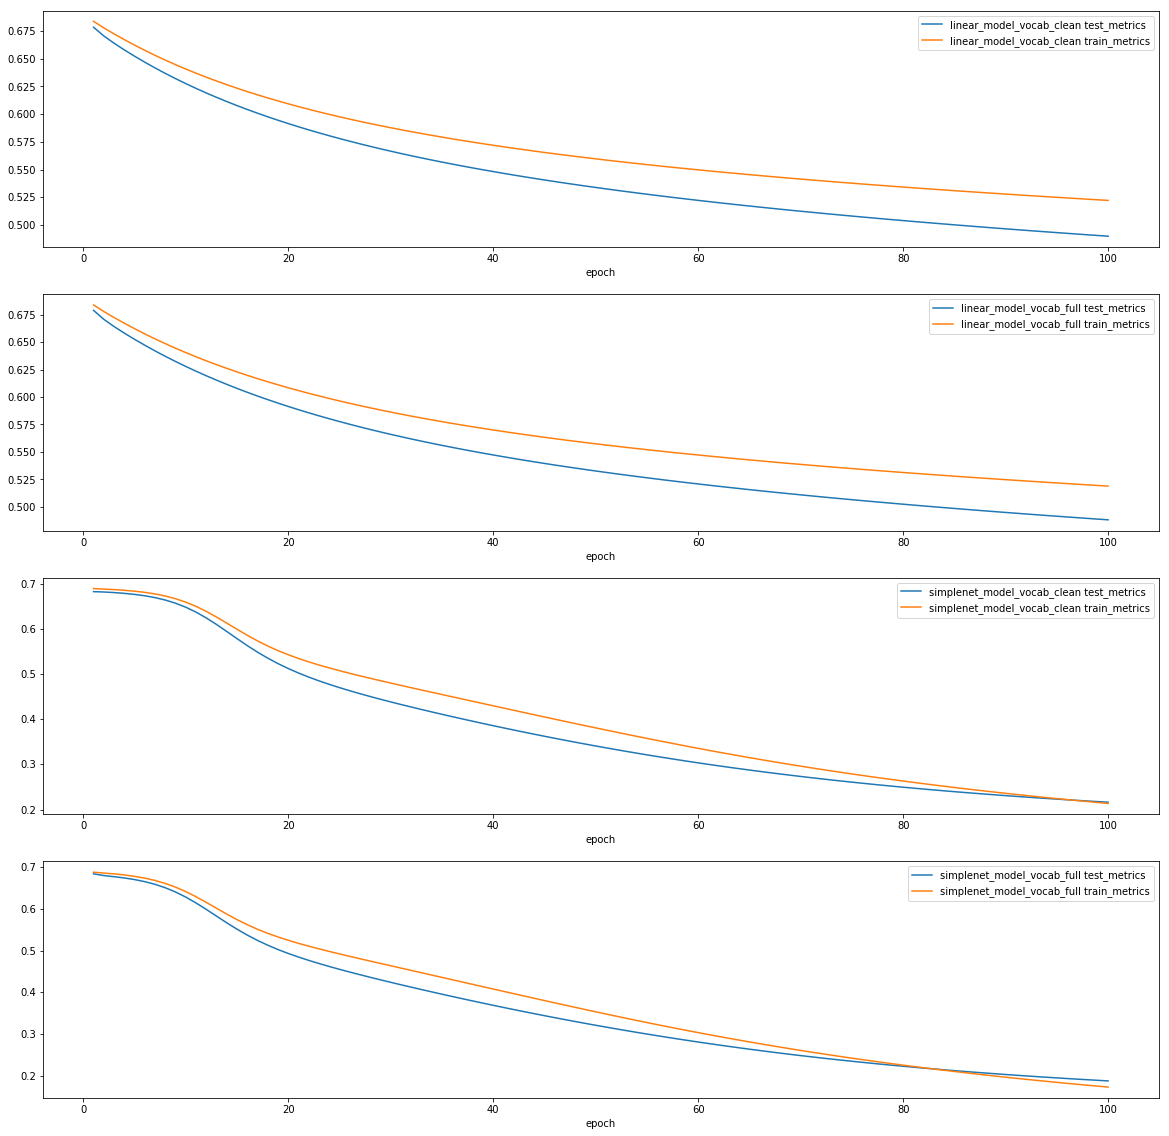

In [12]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=4, figsize=(20, 20))
i=0
for m, m_grp in metrics_df[metrics_df.metric=='bce'].groupby(['model']):
    for d, d_grp in m_grp.groupby('dataset'):
        d_grp.plot(ax=axes[i], x='epoch', y='value', label="%s %s"%(m,d))
    i += 1

There seems to be a "bit" of overfitting happening.
* Not surprising given that we have no regularization what so ever. Would normally include L2 normalization
* But it doesn't seem to bad in the linear model.
* The SimpleNet (sometimes yes / sometimes no) seems to overfit much more significantly.
* Quality of the SimpleNet seems better
* Tried to rerun a bunch of times and overfitting of the different models changes. Not surprising as he don't have proper initialization

## Evaluation: Quality of the model


### Precision, Recall, f1

In [13]:
metrics_df[(metrics_df.dataset=='test_metrics') & (metrics_df.epoch == 80) & ((metrics_df.metric=='precision') | (metrics_df.metric=='recall') | (metrics_df.metric=='f1'))]

,model,epoch,dataset,metric,value
3167,linear_model_vocab_full,80,test_metrics,precision,0.923077
3168,linear_model_vocab_full,80,test_metrics,recall,0.654545
3169,linear_model_vocab_full,80,test_metrics,f1,0.620690
3177,linear_model_vocab_clean,80,test_metrics,precision,0.925000
3178,linear_model_vocab_clean,80,test_metrics,recall,0.672727
3179,linear_model_vocab_clean,80,test_metrics,f1,0.637931
3187,simplenet_model_vocab_full,80,test_metrics,precision,0.945455
3188,simplenet_model_vocab_full,80,test_metrics,recall,0.945455
3189,simplenet_model_vocab_full,80,test_metrics,f1,0.896552
3197,simplenet_model_vocab_clean,80,test_metrics,precision,0.881356


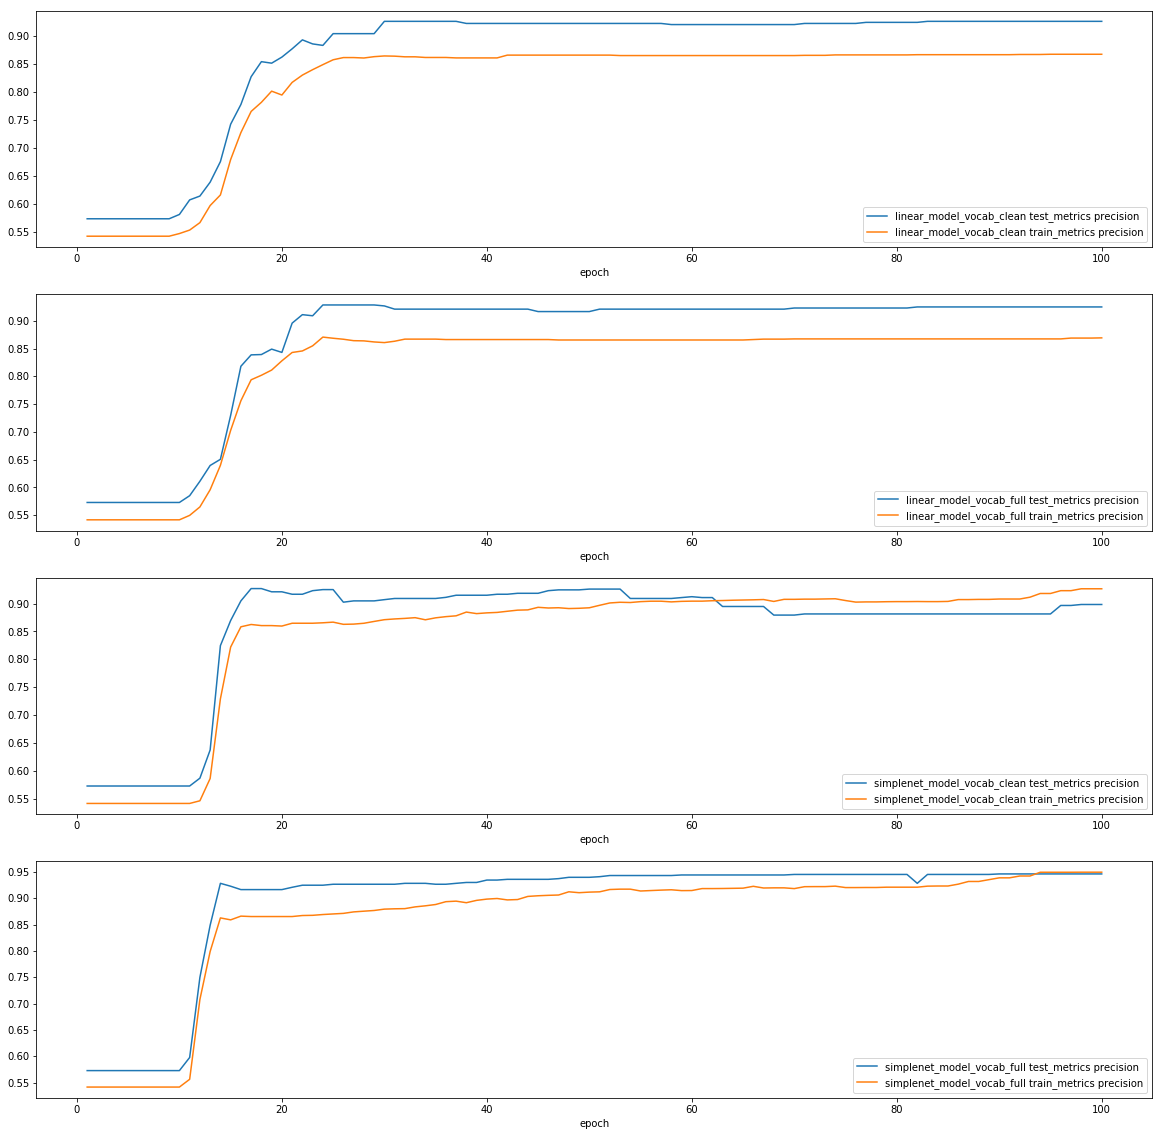

In [14]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=4, figsize=(20, 20))
i=0
for m, m_grp in metrics_df[metrics_df.metric=='precision'].groupby(['model']):
    for d, d_grp in m_grp.groupby('dataset'):
        d_grp.plot(ax=axes[i], x='epoch', y='value', label="%s %s precision"%(m,d))
    i += 1

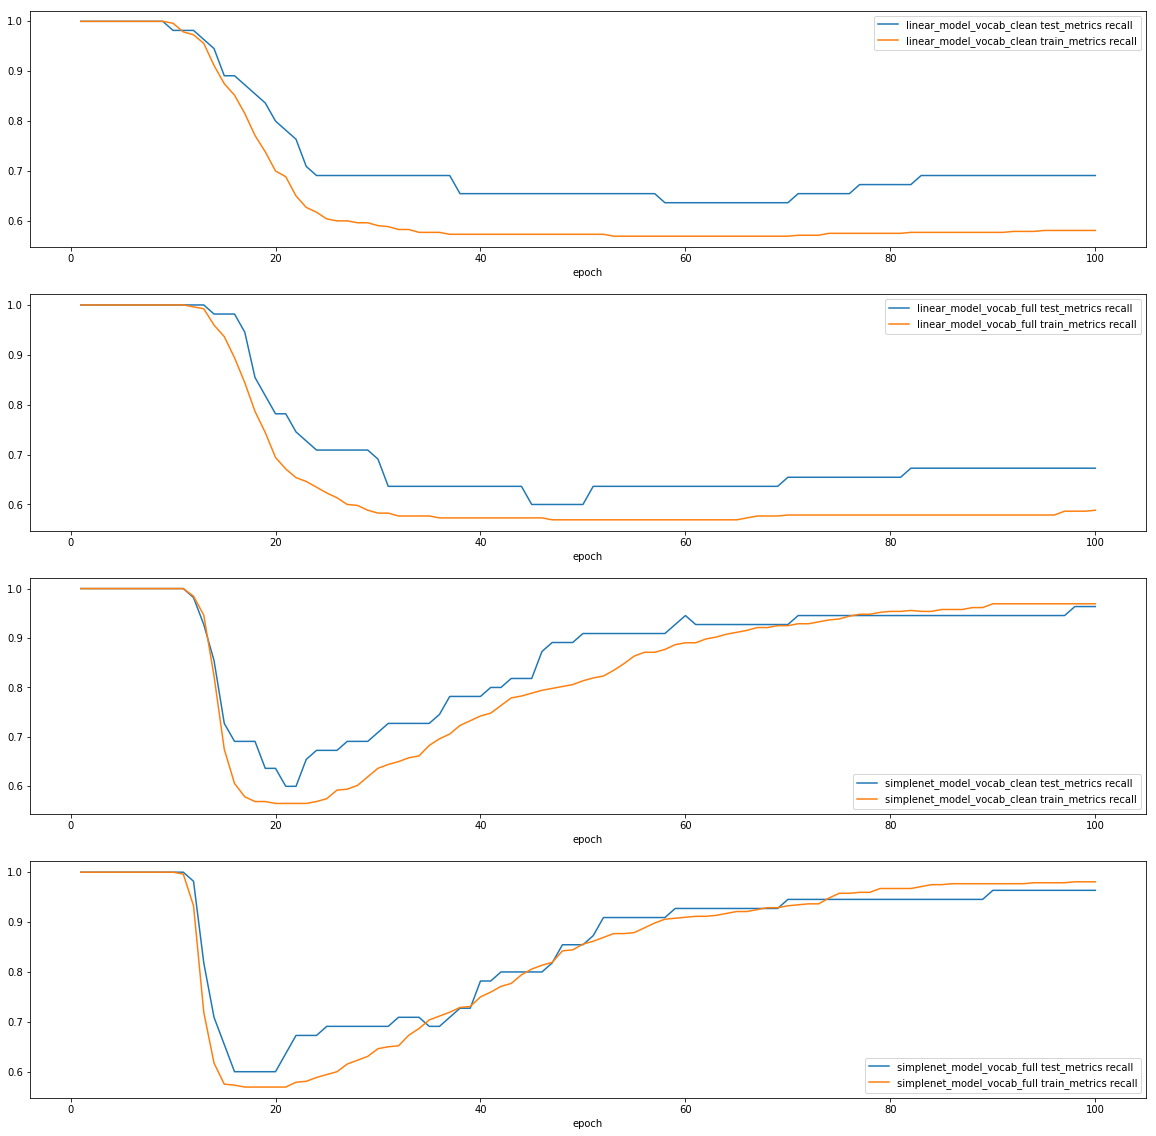

In [15]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=4, figsize=(20, 20))
i=0
for m, m_grp in metrics_df[metrics_df.metric=='recall'].groupby(['model']):
    for d, d_grp in m_grp.groupby('dataset'):
        d_grp.plot(ax=axes[i], x='epoch', y='value', label="%s %s recall"%(m,d))
    i += 1

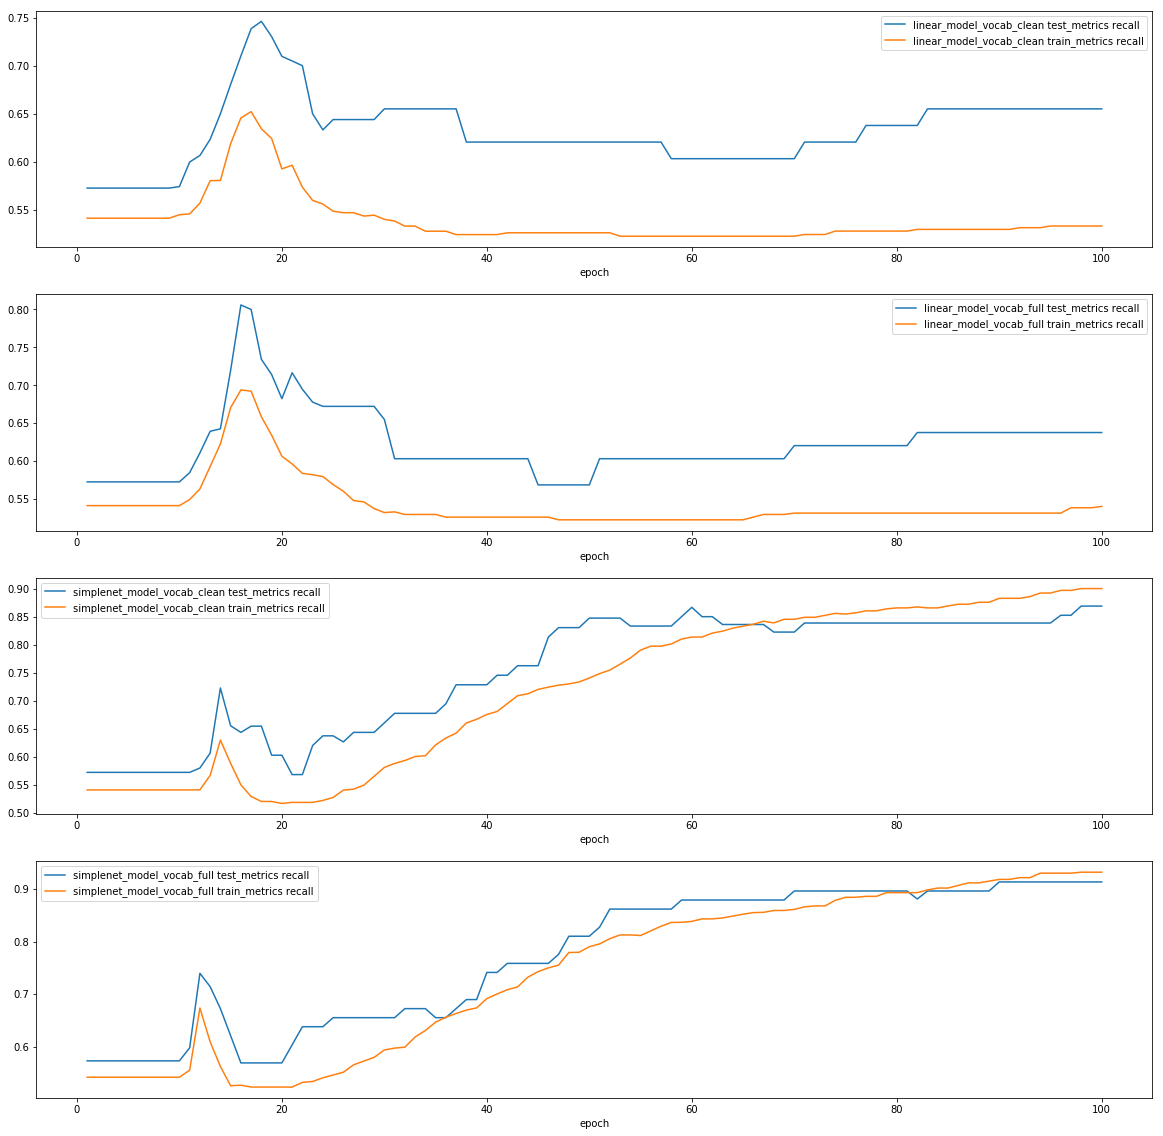

In [16]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=4, figsize=(20, 20))
i=0
for m, m_grp in metrics_df[metrics_df.metric=='f1'].groupby(['model']):
    for d, d_grp in m_grp.groupby('dataset'):
        d_grp.plot(ax=axes[i], x='epoch', y='value', label="%s %s recall"%(m,d))
    i += 1

## Beyond a baseline model
* Definitely add regularization
* Initialize properly the NN
* I would also try to compare a BOW models with a forest model: random forest or boosted decision trees
* Need to tune the hyperparams: vocab size, learning rate, hidden layer size, etc.
* Use pre-trained embeddings
* See list of initial ideas

# Multi-class version of the problem: Kanye, Kantye, Other
* In terms of models, I would apply similar approaches. Change the loss from BCE to CrossEntropy. Sigmoid to softmax. 3 outputs instead of one.
* It would be an extreme minority class problem. E.g. Given a random tweet, very unlikely that it would belong to any of the 2 handles. There aren't really hopes it would perform well
* If we kind of know that it would be run on tweets from the 2 handles most of the times, there is some hope it would work ok.
* Need to do oversampling of the two classes or undersampling of the 'none of the two' class.

# @KimKardashian vs @KimKierkegaard classifier

In [17]:
positive_df = pd.read_json("KimKardashian.json")
negative_df = pd.read_json("KimKierkegaard.json")
positive_df.sample(8)

,id,text
777,977259636318289900,Concealer Kits available NOW on https://t.co/P...
1634,946825819199914000,RT @arshiamoorjani: Ultra Light Beam set in BR...
1759,940039798479249400,KUWTK is on now!!!! I’m watching with you guys!
214,993219373698617300,I swear North reminds me of a mix or me and Ko...
1764,939933914776223700,RT @Hamzaokai_: @TeamKanyeDaily @KimKardashian...
76,990991954212151300,"RT @KKWFRAGRANCE: #KKWBODY, a narcotic elixir ..."
549,983697016768245800,Morning https://t.co/4oKeggHUOd
1155,966026014269825000,My 7 Steps to a Toned Butt https://t.co/3YcmkF...


In [18]:
negative_df.sample(8)

,id,text
998,853958134540447700,RT @KimKierkegaard: I took off those long pres...
626,946060504635772900,@JoyceCarolOates What's questionable about you...
453,964206808008155100,@SelineSigil9 @john_overholt how would you pre...
232,989177022902612000,"@BrooklynSpoke ""injuring toes"""
1313,711065640396841000,"@johnnysunshine @BroderickGreer Okay, they're ..."
1335,706561214395097100,@rabihalameddine Roland for President.
752,925421476529963000,Halloween is fun. What terrifies me is the hou...
1623,512991184592306200,You're the funniest person I know!!! But in yo...


In [19]:
positive_df.count()

id      3351
text    3351
dtype: int64

In [20]:
negative_df.count()

id      1987
text    1987
dtype: int64

## First impressions
* It seems to be less ballanced that the previous example. Would probably oversample the negatives.
* Slight more data. Still very small and the same problems should happen.

## Let's retrain the models

In [21]:
positive_df['label']=1.0
negative_df['label']=0.0
df = pd.concat([positive_df, negative_df]).sample(frac=1.0)
df['tokenized_text'] = [Tokenizer.split(a) for a in df['text']]
df.sample(8)

,id,text,label,tokenized_text
2188,929849234962001900,RT @KKWFRAGRANCE: Crystal Gardenia Citrus avai...,1.0,"[rt, @kkwfragrance, :, crystal, gardenia, citr..."
735,929737383045730300,I am not an apostle and do not speak with God’...,0.0,"[i, am, not, an, apostle, and, do, not, speak,..."
1147,823703265581862900,Then we discovered that life was beautiful. Ev...,0.0,"[then, we, discovered, that, life, was, beauti..."
211,991597975523741700,@kanyewest for presenting *bad* ideas,0.0,"[@kanyewest, for, presenting, *, bad, *, ideas]"
1768,939932411948707800,RT @AKutieNameKim: I will never get over how a...,1.0,"[rt, @akutienamekim, :, i, will, never, get, o..."
121,980847477829046300,"@Exist2Explore ""#1 New Release in Existentiali...",0.0,"[@exist2explore, "", #, 1, new, release, in, ex..."
1427,955882805271105500,My signature soul food menu: https://t.co/fwGL...,1.0,"[my, signature, soul, food, menu, :, https, :,..."
599,981974763198283800,Bundles sold out! We still have the #KKWxMARIO...,1.0,"[bundles, sold, out, !, we, still, have, the, ..."


In [22]:
mask = np.random.rand(len(df)) < test_set_share
train_df = df[~mask]
test_df = df[mask]
trainset_full = BowDataset(train_df)
trainset_clean = BowDataset(train_df, min_num_occurences=2)
testset_full = BowDataset(test_df, min_num_occurences=None, vocab=trainset_full.vocab)
testset_clean = BowDataset(test_df, min_num_occurences=None, vocab=trainset_clean.vocab)
models = {}
models['linear_model_vocab_full'] = (LinearClassifier(trainset_full.vocab), trainset_full, testset_full)
models['linear_model_vocab_clean'] = (LinearClassifier(trainset_clean.vocab), trainset_clean, testset_clean)
models['simplenet_model_vocab_full'] = (
    SimpleNetClassifier(trainset_full.vocab, inner_layer_size), trainset_full, testset_full)
models['simplenet_model_vocab_clean'] = (
    SimpleNetClassifier(trainset_clean.vocab, inner_layer_size), trainset_clean, testset_clean)

trainers = {model_name: ClassifierTrainer(model, train_set, test_set)
            for model_name, (model, train_set, test_set) in models.items()}

num_epochs = 30
metrics = []
for epoch in range(num_epochs):
    for trainer in trainers:
        epoch_metrics = (trainer, trainers[trainer].train_epoch())
        metrics.append(epoch_metrics)

metrics_df = pd.DataFrame(columns=['model', 'epoch', 'dataset', 'metric', 'value'])
for model_name, epoch_metrics in metrics:
    epoch = epoch_metrics["epoch"]
    for dataset_name in ["train_metrics", "test_metrics"]:
        for dataset_metrics in epoch_metrics[dataset_name]:
            metrics_df = metrics_df.append({
                'model': model_name,
                'epoch': epoch,
                'dataset': dataset_name,
                'metric': dataset_metrics[0],
                'value': dataset_metrics[1],
            }, ignore_index=True)

metrics_df.set_index(['epoch','metric','dataset'])
metrics_df

,model,epoch,dataset,metric,value
0,linear_model_vocab_full,1,train_metrics,bce,0.632109
1,linear_model_vocab_full,1,train_metrics,accuracy,0.627752
2,linear_model_vocab_full,1,train_metrics,precision,0.627752
3,linear_model_vocab_full,1,train_metrics,recall,1.000000
4,linear_model_vocab_full,1,train_metrics,f1,0.627752
5,linear_model_vocab_full,1,test_metrics,bce,0.631539
6,linear_model_vocab_full,1,test_metrics,accuracy,0.627863
7,linear_model_vocab_full,1,test_metrics,precision,0.627863
8,linear_model_vocab_full,1,test_metrics,recall,1.000000
9,linear_model_vocab_full,1,test_metrics,f1,0.627863


In [23]:
metrics_df[(metrics_df.dataset=='test_metrics') & (metrics_df.epoch == (num_epochs-1)) & ((metrics_df.metric=='precision') | (metrics_df.metric=='recall') | (metrics_df.metric=='f1'))]

,model,epoch,dataset,metric,value
1127,linear_model_vocab_full,29,test_metrics,precision,0.877743
1128,linear_model_vocab_full,29,test_metrics,recall,0.851064
1129,linear_model_vocab_full,29,test_metrics,f1,0.760870
1137,linear_model_vocab_clean,29,test_metrics,precision,0.875776
1138,linear_model_vocab_clean,29,test_metrics,recall,0.857143
1139,linear_model_vocab_clean,29,test_metrics,f1,0.764228
1147,simplenet_model_vocab_full,29,test_metrics,precision,0.916168
1148,simplenet_model_vocab_full,29,test_metrics,recall,0.930091
1149,simplenet_model_vocab_full,29,test_metrics,f1,0.857143
1157,simplenet_model_vocab_clean,29,test_metrics,precision,0.915916


* linear model seems to work better than on the previous problem (f1:.75 vs f1:.63), not surprising as we are predicting the majority class. It would probably be worse if we would predict the minority class.
* SimpleNet works only slightly better than before (f1:.87 vs f1:.85)